In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vietnam-housing-dataset-2024/vietnam_housing_dataset.csv


In [2]:
file_path = '/kaggle/input/vietnam-housing-dataset-2024/vietnam_housing_dataset.csv'
house_data = pd.read_csv(file_path)
house_data.head()

,Address,Area,Frontage,Access Road,House direction,Balcony direction,Floors,Bedrooms,Bathrooms,Legal status,Furniture state,Price
0,"Dự án The Empire - Vinhomes Ocean Park 2, Xã L...",84.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,Have certificate,NaN,8.60
1,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",60.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,7.50
2,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",90.0,6.0,13.0,Đông - Bắc,Đông - Bắc,5.0,NaN,NaN,Sale contract,NaN,8.90
3,"Đường Nguyễn Văn Khối, Phường 11, Gò Vấp, Hồ C...",54.0,NaN,3.5,Tây - Nam,Tây - Nam,2.0,2.0,3.0,Have certificate,Full,5.35
4,"Đường Quang Trung, Phường 8, Gò Vấp, Hồ Chí Minh",92.0,NaN,NaN,Đông - Nam,Đông - Nam,2.0,4.0,4.0,Have certificate,Full,6.90


# EDA and Feature Engineering

First, I want to look at the target variable: Price

<Axes: xlabel='Price', ylabel='Count'>

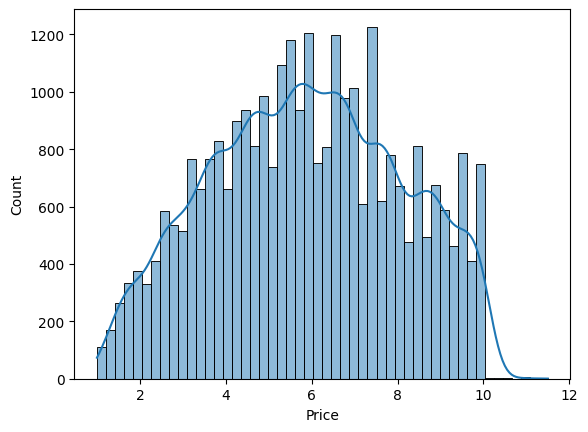

In [3]:
sns.histplot(house_data['Price'], kde=True)

<Axes: xlabel='Price', ylabel='Count'>

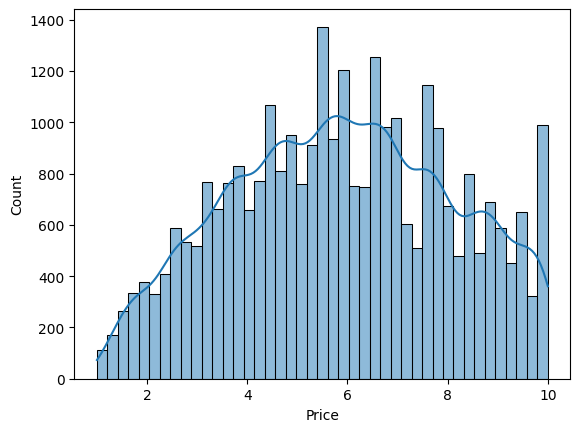

In [4]:
# Filtering outliers
house_data = house_data[house_data['Price'] <= 10]
house_data.reset_index(drop = True, inplace = True)
sns.histplot(house_data['Price'], kde=True)

Its distribution seems not too skewed so there is no need for any transformation. Now let's look at the relationship between it and the numerical features

## Numerical Features

In [5]:
# First, we need to fill N/A values

# Filling NaN in floors, bedrooms, and bathrooms with 1.0 since 0 does not make sense
house_data['Floors'].fillna(1, inplace=True)
house_data['Bedrooms'].fillna(1, inplace=True)
house_data['Bathrooms'].fillna(1, inplace=True)

# Filling NaN in Frontage and Access Road with 0
house_data['Frontage'].fillna(0, inplace=True)
house_data['Access Road'].fillna(0, inplace=True)

house_data.head()

,Address,Area,Frontage,Access Road,House direction,Balcony direction,Floors,Bedrooms,Bathrooms,Legal status,Furniture state,Price
0,"Dự án The Empire - Vinhomes Ocean Park 2, Xã L...",84.0,0.0,0.0,NaN,NaN,4.0,1.0,1.0,Have certificate,NaN,8.60
1,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",60.0,0.0,0.0,NaN,NaN,5.0,1.0,1.0,NaN,NaN,7.50
2,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",90.0,6.0,13.0,Đông - Bắc,Đông - Bắc,5.0,1.0,1.0,Sale contract,NaN,8.90
3,"Đường Nguyễn Văn Khối, Phường 11, Gò Vấp, Hồ C...",54.0,0.0,3.5,Tây - Nam,Tây - Nam,2.0,2.0,3.0,Have certificate,Full,5.35
4,"Đường Quang Trung, Phường 8, Gò Vấp, Hồ Chí Minh",92.0,0.0,0.0,Đông - Nam,Đông - Nam,2.0,4.0,4.0,Have certificate,Full,6.90


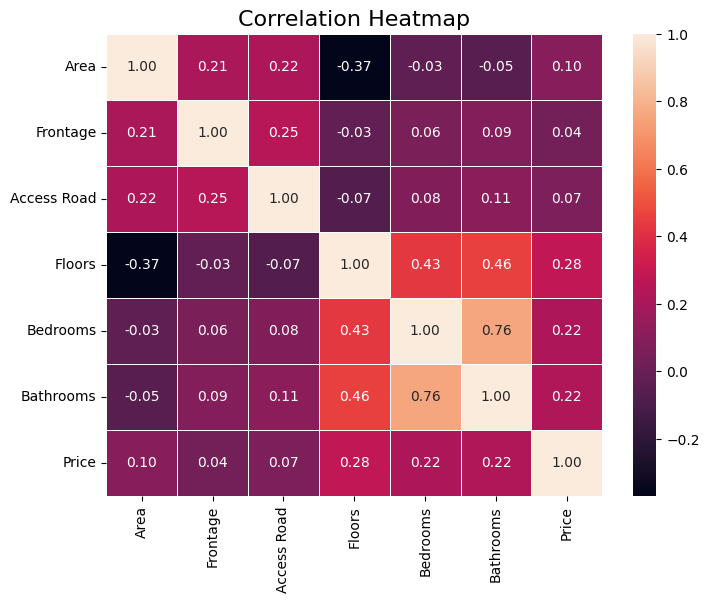

In [6]:
numerical_features = house_data.select_dtypes(include=['number']).columns
corr_matrix = house_data[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5, cbar=True)

plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Floors, Bedrooms, and Bathrooms have the highest correlations with the target variable and with one another, which would be helpful for our FE later. What surprise me is the correlation between Price and Area (which is usually the decisive factor determining the price of a house). But since we are only looking at linear correlation, we may be missing some other type of relationships. So we could use Mutual Information.

In [7]:
#Mutual Information function
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [8]:
# I only want to check Mutual Information of only numerical features
X = house_data[numerical_features]
y = X.pop('Price')

print(make_mi_scores(X, y))

Area           0.246904
Bedrooms       0.111681
Bathrooms      0.106885
Floors         0.106579
Frontage       0.067243
Access Road    0.057663
Name: MI Scores, dtype: float64


Is it interesting? Area now has the most MI here. Anyway, this step is just for demonstration. Since we only have a few features, I think it is advisable to keep all of them for the model later. If we have a lot of features, we could check their correlations and Mutual Information to see what is worth keeping and what is not in order to save some resources and time.

But the MI code is not for nothing, now I want to create PCAs and check their MI to see what I should keep.

In [9]:
#Principal Component function
from sklearn.decomposition import PCA

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [10]:
# I want to choose features having high correlations or MI
high_corr = ['Area', 'Floors', 'Bedrooms', 'Bathrooms']
pca, X_pca, loadings = apply_pca(X[high_corr])
print(loadings)

                PC1       PC2       PC3       PC4
Area      -0.204296  0.836344  0.508715 -0.000505
Floors     0.515413 -0.349349  0.781369  0.042033
Bedrooms   0.583313  0.314207 -0.281625  0.694052
Bathrooms  0.593598  0.282413 -0.226626 -0.718697


In [11]:
make_mi_scores(X_pca, y)

PC4    0.345851
PC1    0.319690
PC3    0.206499
PC2    0.175658
Name: MI Scores, dtype: float64

Seem like all of these PCAs have high MI, and we can see that Floors, Bedrooms, Bathrooms, and Area have some potential correlations with each other. So let create some new features with them 

In [12]:
# New features based on loadings
X['Total Room'] = X['Bedrooms'] + X['Bathrooms']
X['Total Room + Floor'] = X['Total Room'] + X['Floors']
X['Bedrooms * Area'] = X['Bedrooms'] * X['Area']
X['Bathrooms * Area'] = X['Bathrooms'] * X['Area']
X['Area_Floors'] = X['Area'] * X['Floors']

#Add all PCAs
X = X.join(X_pca)

In [13]:
print(make_mi_scores(X, y))

PC4                   0.347188
PC1                   0.318564
Area_Floors           0.287544
Area                  0.245292
Bedrooms * Area       0.213083
PC3                   0.204278
Bathrooms * Area      0.202468
PC2                   0.174826
Total Room            0.120341
Total Room + Floor    0.114723
Bathrooms             0.105306
Floors                0.103166
Bedrooms              0.102511
Frontage              0.063161
Access Road           0.062510
Name: MI Scores, dtype: float64


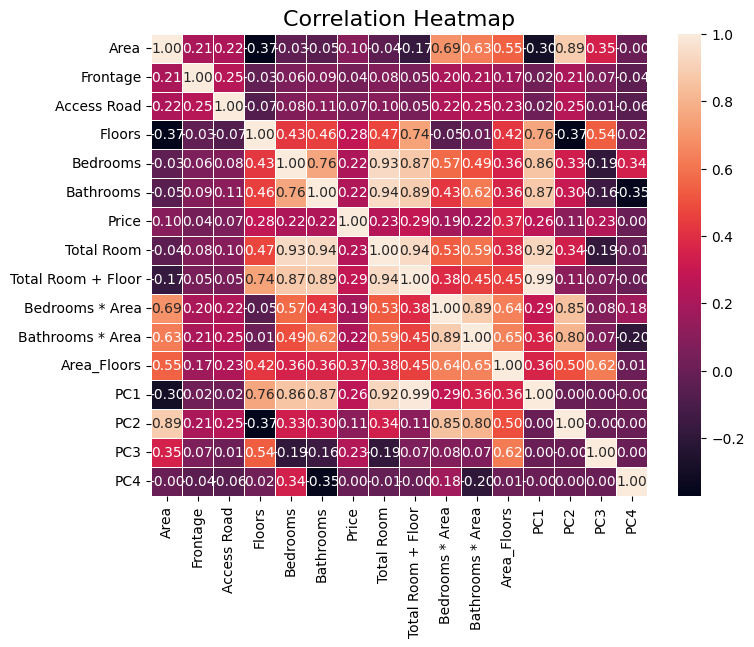

In [14]:
#Let see the new features' correlation
house_data = house_data.assign(**X)
numerical_features = house_data.select_dtypes(include=['number']).columns
corr_matrix = house_data[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5, cbar=True)

plt.title('Correlation Heatmap', fontsize=16)
plt.show()


It's really cool to see PC4 has 0 linear correlation with Price but has the highest MI.

## Categorical Features

In [15]:
# Check null values
house_data.isnull().sum()

Address                   0
Area                      0
Frontage                  0
Access Road               0
House direction       21232
Balcony direction     24975
Floors                    0
Bedrooms                  0
Bathrooms                 0
Legal status           4504
Furniture state       14113
Price                     0
Total Room                0
Total Room + Floor        0
Bedrooms * Area           0
Bathrooms * Area          0
Area_Floors               0
PC1                       0
PC2                       0
PC3                       0
PC4                       0
dtype: int64

Filling N/A in Legal and Furniture with None (a house has no legal paper attached or no furniture equipped)

In [16]:
house_data['Legal status'].fillna('None', inplace=True)
house_data['Furniture state'].fillna('None', inplace=True)

Considering both 'direction' columns, I believe we can drop them as the null values are more than 2/3 and they do not contribute much to the price in real life

In [17]:
house_data.drop('House direction', inplace = True, axis = 1)
house_data.drop('Balcony direction', inplace = True, axis = 1)

The 'Address' column gives us two important features that I can think of:
1. The province where the house is located
2. Whether the house belongs to a project of a new urban area (has the word "Dự án")

In [18]:
house_data['Province'] = house_data['Address'].str.split(", ").str[-1].str.replace(".", "")
house_data['Project'] = house_data['Address'].str.lower().str.contains('dự án').map({True: 1, False: 0})

house_data.head()

,Address,Area,Frontage,Access Road,Floors,Bedrooms,Bathrooms,Legal status,Furniture state,Price,...,Total Room + Floor,Bedrooms * Area,Bathrooms * Area,Area_Floors,PC1,PC2,PC3,PC4,Province,Project
0,"Dự án The Empire - Vinhomes Ocean Park 2, Xã L...",84.0,0.0,0.0,4.0,1.0,1.0,Have certificate,None,8.60,...,6.0,84.0,84.0,336.0,-1.233571,-0.690709,1.273874,-0.106261,Hưng Yên,1
1,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",60.0,0.0,0.0,5.0,1.0,1.0,None,None,7.50,...,7.0,60.0,60.0,300.0,-0.781186,-1.345727,1.551119,-0.077433,Hưng Yên,1
2,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",90.0,6.0,13.0,5.0,1.0,1.0,Sale contract,None,8.90,...,7.0,90.0,90.0,450.0,-0.908671,-0.823831,1.868568,-0.077748,Hưng Yên,1
3,"Đường Nguyễn Văn Khối, Phường 11, Gò Vấp, Hồ C...",54.0,0.0,3.5,2.0,2.0,3.0,Have certificate,Full,5.35,...,7.0,108.0,162.0,108.0,-0.670519,-0.172839,-0.578574,-0.618163,Hồ Chí Minh,0
4,"Đường Quang Trung, Phường 8, Gò Vấp, Hồ Chí Minh",92.0,0.0,0.0,2.0,4.0,4.0,Have certificate,Full,6.90,...,10.0,368.0,368.0,184.0,0.311529,1.080529,-0.690546,-0.161520,Hồ Chí Minh,0


In [19]:
# I want to drop rows that belong to provinces with fewer than 5 occurrences
unique_provinces = house_data['Province'].value_counts()
unique_provinces = unique_provinces[unique_provinces < 5].index
house_data = house_data[~house_data['Province'].isin(unique_provinces)]

# Dropping Address since we don't need it anymore
house_data.drop('Address', axis = 1, inplace = True)

Let see if my intuition is correct

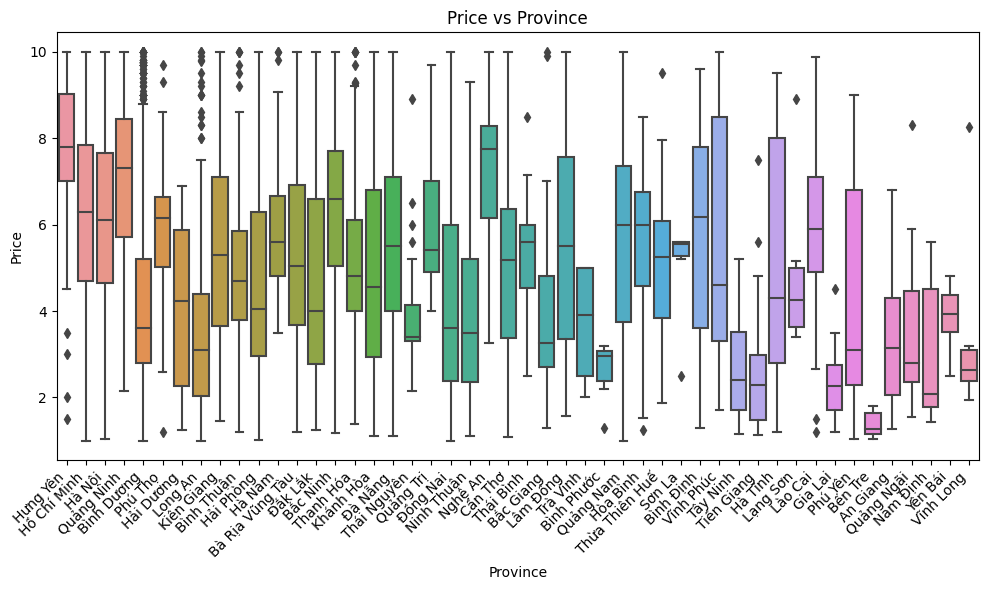

In [20]:
# Create the box plot for Price vs Province
plt.figure(figsize=(10, 6))
sns.boxplot(x='Province', y='Price', data=house_data)
plt.title('Price vs Province')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

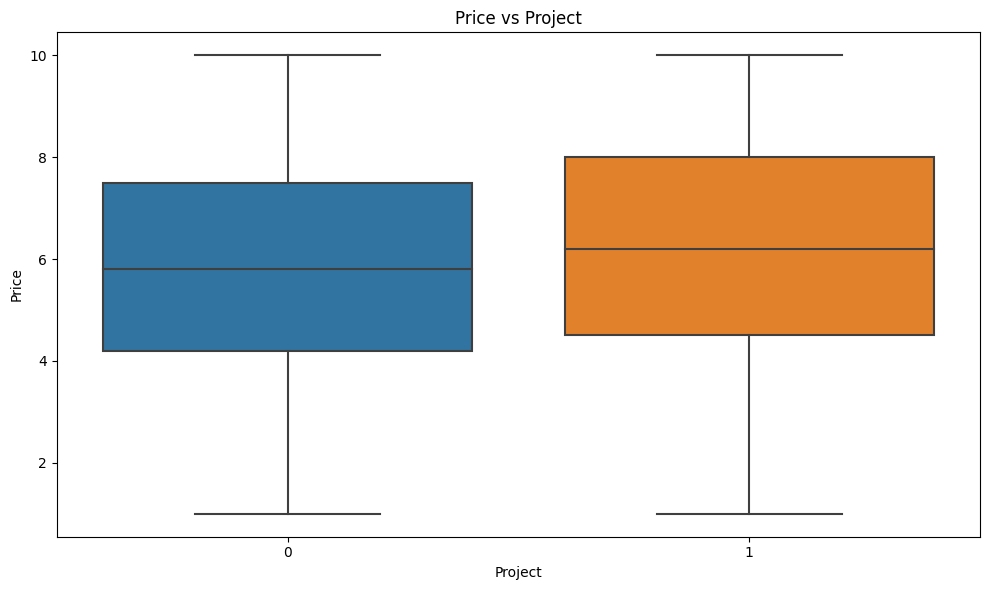

In [21]:
# Create the box plot for Price vs Project
plt.figure(figsize=(10, 6))
sns.boxplot(x='Project', y='Price', data=house_data)
plt.title('Price vs Project')

# Show the plot
plt.tight_layout()
plt.show()

We can see that each Province has different Price ranges, so this new feature is very informative for the model. Meanwhile, the Project column seems to have not that much of a difference in Price range (but let just keep it for now).

# Model

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

X = house_data.copy()
y = X.pop('Price')
X = pd.get_dummies(X)
X.head()

,Area,Frontage,Access Road,Floors,Bedrooms,Bathrooms,Total Room,Total Room + Floor,Bedrooms * Area,Bathrooms * Area,...,Province_Thừa Thiên Huế,Province_Tiền Giang,Province_Trà Vinh,Province_Tây Ninh,Province_Vĩnh Long,Province_Vĩnh Phúc,Province_Yên Bái,Province_Đà Nẵng,Province_Đắk Lắk,Province_Đồng Nai
0,84.0,0.0,0.0,4.0,1.0,1.0,2.0,6.0,84.0,84.0,...,False,False,False,False,False,False,False,False,False,False
1,60.0,0.0,0.0,5.0,1.0,1.0,2.0,7.0,60.0,60.0,...,False,False,False,False,False,False,False,False,False,False
2,90.0,6.0,13.0,5.0,1.0,1.0,2.0,7.0,90.0,90.0,...,False,False,False,False,False,False,False,False,False,False
3,54.0,0.0,3.5,2.0,2.0,3.0,5.0,7.0,108.0,162.0,...,False,False,False,False,False,False,False,False,False,False
4,92.0,0.0,0.0,2.0,4.0,4.0,8.0,10.0,368.0,368.0,...,False,False,False,False,False,False,False,False,False,False


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Ridge Regression with Cross-Validation
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
ridge_best = ridge_cv.best_estimator_

# Lasso Regression with Cross-Validation
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)
lasso_best = lasso_cv.best_estimator_

# Make predictions on the testing set using the best models
ridge_pred = ridge_best.predict(X_test)
lasso_pred = lasso_best.predict(X_test)

# Calculate RMSE for Ridge and Lasso
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))

# Output the RMSE values and best alpha values
print(f"Ridge Regression - Best Alpha: {ridge_cv.best_params_['alpha']}, RMSE: {ridge_rmse:.2f}")
print(f"Lasso Regression - Best Alpha: {lasso_cv.best_params_['alpha']}, RMSE: {lasso_rmse:.2f}")

Ridge Regression - Best Alpha: 1, RMSE: 1.85
Lasso Regression - Best Alpha: 0.01, RMSE: 1.86


In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree = 0.7,
    gamma = 0.1,
    learning_rate = 0.01,
    max_depth = 7,
    n_estimators = 1000,
    subsample = 0.9)

xgb_model.fit(X_train, y_train, verbose=True)
y_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {xgb_rmse:.2f}")

RMSE: 1.56


In [25]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape * 100:.2f}%")

MAPE: 27.19%


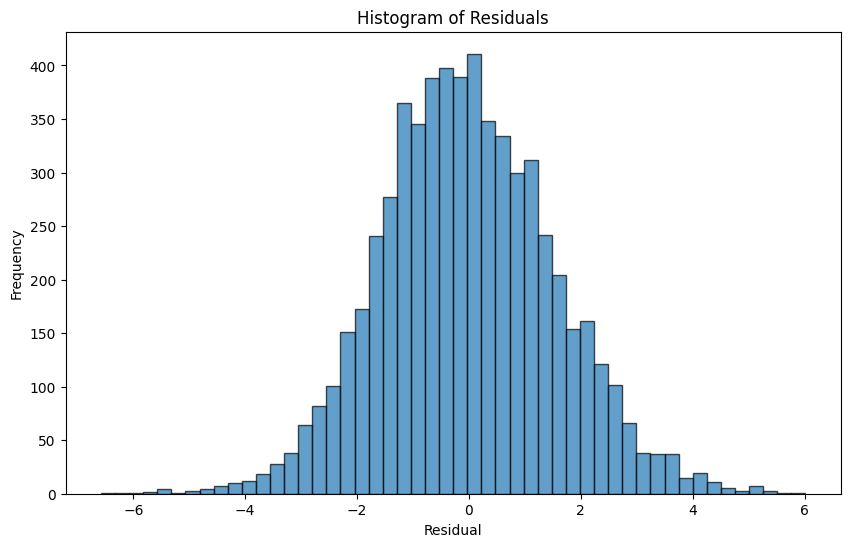

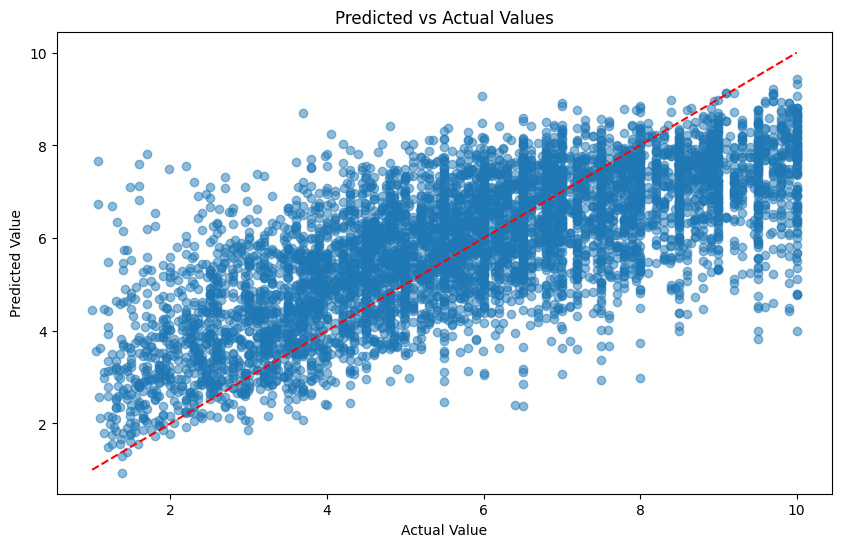

In [26]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([1, 10], [1, 10], 'r--')  # Diagonal line for reference
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

So this is my attempt at this dataset. The MAPE and RMSE indicates that this model can still be improved. Nevertheless, as I have spent only a month studying on Kaggle, I am pretty content with my results in the meantime. If you have another approach that you believe can perform better, feel free to share it. Thank you for your time!